<a href="https://colab.research.google.com/github/aldoalprak/Mask_NoMask_Classification/blob/master/mask_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Library

In [0]:
%tensorflow_version 2.x

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls  "/content/drive/My Drive/Mask_Datasets/"

Model  Train  Validation


### Tensorflow JS

In [4]:
pip install tensorflowjs

     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 92kB 4.2MB/s 
     |████████████████████████████████| 144.4MB 68kB/s 
     |████████████████████████████████| 256kB 35.3MB/s 
     |████████████████████████████████| 921kB 40.1MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=9fc18f61ed9a111b56ee05af6417f7faf1645bdcb49f2262a5987c83706ec36a
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation:

In [5]:
!tensorflowjs_converter --version


tensorflowjs 1.7.4r1

Dependency versions:
  keras 2.3.0-tf
  tensorflow 2.2.0


### Processing

In [0]:
#define directory

base_dir = "/content/drive/My Drive/Mask_Datasets/"

train_dir = os.path.join(base_dir, "Train")
train_mask_dir = os.path.join(train_dir, "Mask")
train_no_mask_dir = os.path.join(train_dir, "No_mask")

val_dir = os.path.join(base_dir, "Validation")
val_mask_dir = os.path.join(val_dir, "Mask")
val_no_mask_dir = os.path.join(val_dir, "No_mask")


In [7]:
#Understanding the data

num_mask_train = len(os.listdir(train_mask_dir))
num_no_mask_train = len(os.listdir(train_no_mask_dir))
total_train = num_mask_train + num_no_mask_train

num_mask_val = len(os.listdir(val_mask_dir))
num_no_mask_val = len(os.listdir(val_no_mask_dir))
total_val = num_mask_val + num_no_mask_val

print("train data: mask ==> ", num_mask_train)
print("train data: no_mask ==> ", num_no_mask_train)
print("total train data ==> ", total_train)
print("                      ")
print("validation data: mask ==> ", num_mask_val)
print("validation data: no_mask ==> ", num_no_mask_val)
print("total validation data ==> ", total_val)


train data: mask ==>  350
train data: no_mask ==>  400
total train data ==>  750
                      
validation data: mask ==>  150
validation data: no_mask ==>  200
total validation data ==>  350


In [0]:
batch_size = 100
epochs = 10
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [25]:
#Data Preparation

train_image_generator = ImageDataGenerator(
                          rescale=1./255, 
                          horizontal_flip=True,
                          rotation_range=45,
                          shear_range=0.2,
                          fill_mode='nearest'
                        )

train_data_gen = train_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)

val_image_generator = ImageDataGenerator(rescale=1./255)

val_data_gen = val_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = val_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)


Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


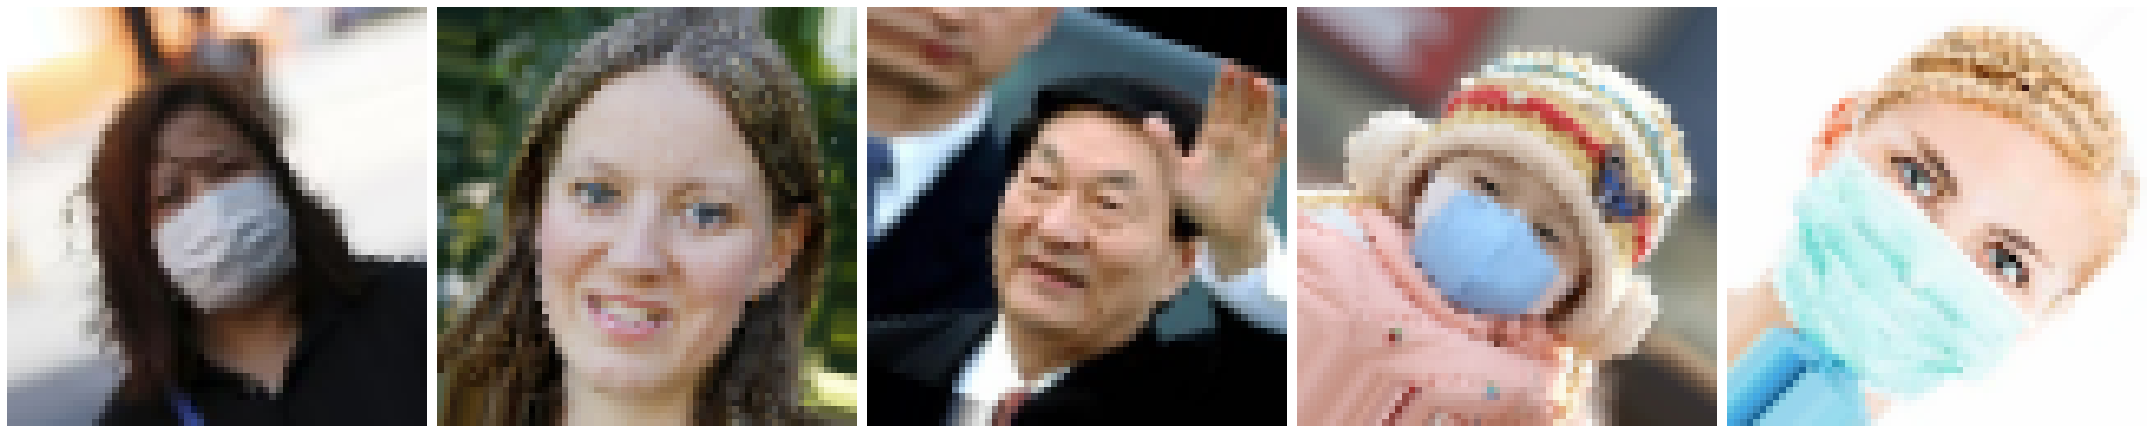

In [10]:
#visualize dataset
sample_training_image, _ = next(train_data_gen)

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(30,30))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

plotImages(sample_training_image[:5])

In [36]:
#model

# convolutional_block = convolutional_blocks = [
#   Conv2D(32,(3,3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#   MaxPooling2D(pool_size=(2,2)),
#   Conv2D(32, (3,3), activation="relu"),
#   MaxPooling2D(pool_size=(2,2)),
#   Flatten(),
#   Dense(128, activation="relu"),
#   Dense(1, activation="sigmoid")
# ]

# model = Sequential(convolutional_blocks)


pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3], include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
  layer.traineable = False

last_layer = pre_trained_model.get_layer("block_7_add")
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)

In [0]:
## compile

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [35]:
history = model.fit(
    train_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps= total_val // batch_size
)

Epoch 1/10
7/7 [==============================] - 59s 8s/step - loss: 0.6082 - accuracy: 0.7292 - val_loss: 0.4824 - val_accuracy: 0.9933
Epoch 2/10
7/7 [==============================] - 57s 8s/step - loss: 0.5305 - accuracy: 0.9000 - val_loss: 0.7135 - val_accuracy: 0.6133
Epoch 3/10
7/7 [==============================] - 57s 8s/step - loss: 0.5123 - accuracy: 0.9431 - val_loss: 0.7299 - val_accuracy: 0.5833
Epoch 4/10
7/7 [==============================] - 59s 8s/step - loss: 0.5373 - accuracy: 0.9262 - val_loss: 0.7405 - val_accuracy: 0.5767
Epoch 5/10
7/7 [==============================] - 56s 8s/step - loss: 0.5245 - accuracy: 0.9369 - val_loss: 0.6901 - val_accuracy: 0.6467
Epoch 6/10
7/7 [==============================] - 59s 8s/step - loss: 0.5175 - accuracy: 0.9529 - val_loss: 0.6011 - val_accuracy: 0.7900
Epoch 7/10
7/7 [==============================] - 56s 8s/step - loss: 0.5280 - accuracy: 0.9523 - val_loss: 0.5617 - val_accuracy: 0.8700
Epoch 8/10
7/7 [==================

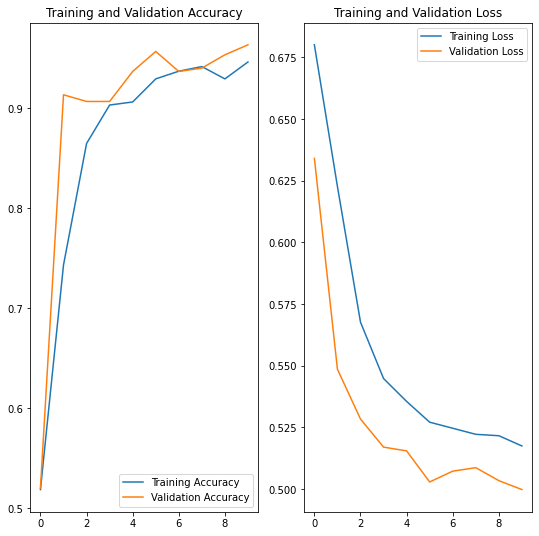

In [15]:
#plot loss & acc

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
evaluate = model.evaluate(val_data_gen, steps=total_val/batch_size)
print(evaluate)

4/3 [==================================] - 8s 2s/step - loss: 0.4995 - accuracy: 0.9657
[0.49950137734413147, 0.9657142758369446]


### Saving the model

In [0]:
tfjs_target_dir = "/content/drive/My Drive/Mask_Datasets/Model/"

In [0]:
import tensorflowjs as tfjs

In [19]:
tfjs.converters.save_keras_model(model, tfjs_target_dir)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
